# Make_nofire_points

In [1]:
import random
import pandas as pd
import geopandas as gpd
import os

def make_random_dataset(start_year, end_year, num_samples, filepath): 
    """
    Generate and save synthetic data representing non-wildfire occurrences within Gangwon Province.
    Seasonal ratios are specified differently for spring, summer, fall, and winter.
    A total of 9477 samples are generated (based on a 1:9 ratio compared to wildfire data).
    """
    seasons = ['spring', 'fall', 'winter', 'else']
    season_weights = [0.6, 0.2, 0.1, 0.1]
    min_latitude, max_latitude = 37.03353708, 38.61370931
    min_longitude, max_longitude = 127.0950376, 129.359995

    # Generate random timestamps
    dates = []
    for _ in range(num_samples):
        year = random.randint(start_year, end_year)
        hour = random.randint(0, 23)
        season = random.choices(seasons, weights=season_weights)[0]
        if season == 'spring':
            month = random.randint(2, 5)
        elif season == 'fall':
            month = random.randint(11, 12)
        elif season == 'winter':
            month = random.randint(6, 10)
        else:
            month = random.randint(1, 1)
        day = random.randint(1, 28)
        minute, second = 0, 0
        time = pd.Timestamp(year, month, day, hour, minute, second)
        dates.append(time)
    
    dates_df = pd.DataFrame(dates, columns=['Date'])
    dates_df['date'] = pd.to_datetime(dates_df['Date']).dt.strftime('%Y%m%d')
    dates_df['time'] = pd.to_datetime(dates_df['Date']).dt.strftime('%H%M%S')
    dates_df["date"] = dates_df["date"].str.zfill(8)
    dates_df["time"] = dates_df["time"].str.zfill(6)
    dates_df.drop('Date', axis=1, inplace=True)

    # Generate random coordinates within Gangwon Province
    coordinates = []
    for _ in range(10000):  # Generate more than enough samples
        while True:
            latitude = random.uniform(min_latitude, max_latitude)
            longitude = random.uniform(min_longitude, max_longitude)
            coordinate = (latitude, longitude)
            if coordinate not in coordinates:
                coordinates.append((longitude, latitude))
                break

    df = pd.DataFrame(coordinates, columns=['lon', 'lat'])
    df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
    df.crs = "EPSG:4326"
    df.to_file('temp.shp')  # Save temporary shapefile
    df = gpd.read_file('temp.shp')
    gangwon_df = gpd.read_file("data/gw_boundary/boundary.shp")
    gangwon_boundary = gangwon_df.geometry.unary_union
    df = df[df.geometry.within(gangwon_boundary)]
    df = df.sample(9477, replace=True).reset_index(drop=True)  # Sample 9477 records
    os.remove('temp.shp')
    df.drop('geometry', axis=1, inplace=True)

    # Merge date and coordinate data
    notfire = pd.concat([dates_df.iloc[:1053], df], axis=1)
    notfire['input'] = notfire['date'].astype(str) + notfire['time'].str[:2].str.zfill(2)

    # Save result
    notfire.to_csv(filepath, index=False)


C:\Users\EBDL\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\EBDL\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
make_random_dataset(2011, 2022, 1053, "Data/gangwon_nofire(2011-2022).csv")

# Check_nofiredata

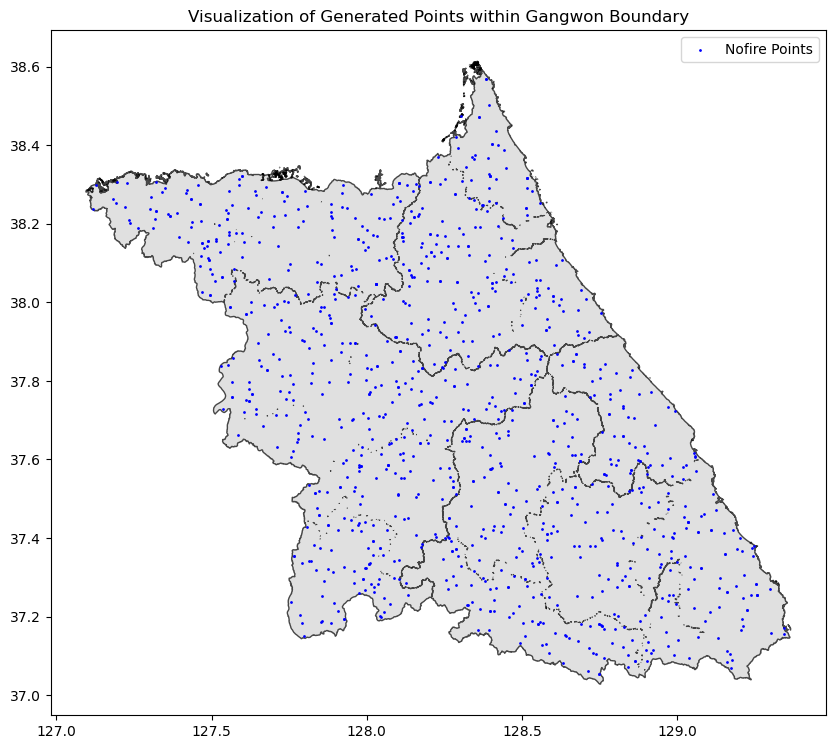

In [6]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Set file paths for Gangwon boundary shapefile and generated data
boundary_shp_path = "data/gw_boundary/boundary.shp"  # Path to Gangwon Province boundary shapefile
data_file_path = "gangwon_nofire(2011-2022).csv"  # Path to the generated no-fire dataset

# Load the data
data = pd.read_csv(data_file_path)

# Convert coordinate data to a GeoDataFrame
geo_data = gpd.GeoDataFrame(
    data, 
    geometry=gpd.points_from_xy(data['lon'], data['lat']),
    crs="EPSG:4326"  # WGS84 coordinate system
)

# Load Gangwon Province boundary shapefile
gangwon_boundary = gpd.read_file(boundary_shp_path)

# Visualization
fig, ax = plt.subplots(figsize=(10, 10))
gangwon_boundary.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.7, label="Gangwon Boundary")
geo_data.plot(ax=ax, color='blue', markersize=1, label="Nofire Points")

plt.title("Visualization of Generated Points within Gangwon Boundary")
plt.legend()
plt.show()


# Weather_matching_nofire

In [12]:
from tqdm import tqdm
from datetime import datetime
import pandas as pd
import numpy as np

# Load ASOS station list with coordinates
loc_data = pd.read_csv("Data/ASOS/ASOS_loc_list.csv")  # ASOS station ID and coordinates
o_data = pd.read_csv("Data/gangwon_nofire(2011-2022).csv")

# Convert 'input' column to string and remove decimal points
o_data['input'] = o_data['input'].astype(str).str.split('.').str[0]

result = []

# Loop over each no-fire sample
for i in tqdm(range(len(o_data))):
    year = o_data['input'][i][:4]

    # Load hourly ASOS weather data by year
    df_asos_hr = pd.read_csv(f'data/ASOS/ASOS_Hr/ASOS_Hr_{year}.csv', low_memory=False)

    # Convert date and time to target format
    date = datetime.strptime(o_data['input'][i], "%Y%m%d%H")
    date = date.strftime("%Y-%m-%d %H:%M")

    # Filter data by matching timestamp
    df_asos_hr = df_asos_hr[df_asos_hr['일시'] == date]
    df_asos_hr = df_asos_hr.reset_index(drop=True)

    # Add sample index and station coordinates
    df_asos_hr['num'] = i
    df_asos_hr['longitude'] = [
        loc_data[loc_data['지점번호'] == df_asos_hr['지점'][i_asos_hr]]['lon'].values[0]
        if loc_data[loc_data['지점번호'] == df_asos_hr['지점'][i_asos_hr]]['lon'].shape[0] != 0
        else np.nan
        for i_asos_hr in range(df_asos_hr.shape[0])
    ]
    df_asos_hr['latitude'] = [
        loc_data[loc_data['지점번호'] == df_asos_hr['지점'][i_asos_hr]]['lat'].values[0]
        if loc_data[loc_data['지점번호'] == df_asos_hr['지점'][i_asos_hr]]['lat'].shape[0] != 0
        else np.nan
        for i_asos_hr in range(df_asos_hr.shape[0])
    ]

    # Select necessary columns and save to individual file
    df_asos_hr = df_asos_hr[['num', '지점', 'longitude', 'latitude', '일시', '습도(%)', '풍속(m/s)', '강수량(mm)', '기온(°C)']]
    df_asos_hr.columns = ['num', 'loc_info', 'lon', 'lat', 'time', 'humidity', 'wind_sp', 'rainfall', 'temp']
    df_asos_hr.to_csv(f'Data/Climate_data/data_{i}.csv', encoding='cp949', index=False)

# Merge all saved climate files into one
for i in range(len(o_data)):
    tmp = pd.read_csv(f"Revision_data/data_set(nofire)/climate_data/data_{i}.csv", encoding='cp949')
    result.append(tmp)

# Save the final merged dataset
weather_data = pd.concat(result, ignore_index=True)
weather_data.to_csv(f"Data/final_climate_data.csv", encoding='cp949', index=False)

print("--> Complete")
print("---------------")


100%|██████████████████████████████████████████████████████████████████████████████| 1053/1053 [47:37<00:00,  2.71s/it]


--> Complete
---------------
